# Car Autoencoder (CIFAR-10)

In [2]:
# import
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten, Dropout, AveragePooling2D
from keras.models import Model, load_model, model_from_json 
from keras.datasets import mnist, cifar10
from utils.IntegratedGradients import * 
from utils.image_utils import get_images_train, plot_side_by_side, gray_scale
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# constants
IMG_SIZE = 32
NUM_CHANNELS = 3

Using TensorFlow backend.


## Training Data

### Load cars from CIFAR-10

In [3]:
def load_CIFAR10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Pixel values go from 0 to 255. 
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    return (x_train, y_train, x_test, y_test)

def select_car_images():
    (x_train, y_train, x_test, y_test) = load_CIFAR10()

    # we only want 'car' images (labeled 1): filter the rest out
    not_cars = np.where(y_train!=1)[0]
    x_train = np.delete(x_train, not_cars, axis=0)
    y_train = np.delete(y_train, not_cars, axis=0)

    not_cars = np.where(y_test!=1)[0]
    x_test = np.delete(x_test, not_cars, axis=0)
    y_test = np.delete(y_test, not_cars, axis=0)
    
    return (x_train, y_train, x_test, y_test)

# verify
# (x_train, _, _, _) = select_car_images()
# r = random.randint(0, x_train.shape[0]-1)
# plt.imshow(x_train[r].reshape(IMG_SIZE, IMG_SIZE, 3))
# plt.show()

### Augment training data with rotations, flips, and whitening

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Wrapper around ImageDataGenerator. 
def augment_data(generator, x_train, save_dir, iterations=20, batch_size=256):
    i = 0
    for batch in generator.flow(x_train, batch_size=256, save_to_dir=save_dir, save_prefix='car', save_format='jpeg'):
        i += 1
        if i > iterations:
            break # otherwise the generator would loop indefinitely

In [11]:
# Run this after creating a clean augmented_images/ directory. 

(x_train, _, _, _) = select_car_images()

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=[0.7, 1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

augment_data(datagen, x_train, save_dir='/Users/vwr/augmented_images/')

augmented_car_flip_zoom = get_images_train('augmented_car_flip_zoom.npy', train_dir = '/Users/vwr/augmented_images',
                                           refresh=True)

In [ ]:
# Run this after creating a clean augmented_images_zca/ directory. 

datagen = ImageDataGenerator(
    zoom_range=[0.8, 1],
    rescale=1./255,
    zca_whitening=True)

datagen.fit(x_train)

augment_data(datagen, x_train, save_dir='/Users/vwr/augmented_images_zca/', iterations=10)

augmented_zca = get_images_train('augmented_car_zca.npy', train_dir='/Users/vwr/augmented_images_zca',\
                                 refresh=True)

In [ ]:
# Run this after creating a clean augmented_images_feat_std/ directory. 

datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True, 
    featurewise_std_normalization=True)

datagen.fit(x_train)

augment_data(datagen, x_train, save_dir='/Users/vwr/augmented_images_feat_std/', iterations=10)

augmented_feat_std = get_images_train('augmented_car_feat_std.npy', train_dir = '/Users/vwr/augmented_images_feat_std',
                                      refresh=True)

#### Create final training data

In [ ]:
car_train = np.concatenate((x_train, augmented_car_flip_zoom, augmented_zca, augmented_feat_std), axis = 0)
print(car_train.shape)

## Architecture: Convolutional encoder + Dense decoder

In [32]:
from keras.layers import Reshape
from keras.optimizers import Adam

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

# build the network
x = Dropout(0.15)(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(x)
x = AveragePooling2D((2, 2), padding='same')(x)
# x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = AveragePooling2D((2, 2,), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
encoded = Dense(2000, activation='relu')(encoded)

# decoder
decoded = Dense(3072, activation="sigmoid")(encoded)
decoded = Reshape((IMG_SIZE, IMG_SIZE, NUM_CHANNELS))(decoded)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(lr=0.0015), loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d_3 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_4 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 64)          36928     
__________

In [ ]:

# train
autoencoder.fit(car_train, car_train, epochs=15, batch_size=300, shuffle=True)


#### (Optional) Save/Load model

In [33]:
# autoencoder.save("0.5209_car_convolutional_autoencoder_20000_examples_60_epochs")
# autoencoder.save("0.5276_dropout_car_conv_autoencoder")

# boom.save_weights("0.5276_dropout_car_conv_autoencoder_weights")
# j = boom.to_json()
# json_file = open("0.5276_dropout_car_conv_autoencoder_architecture.json", "w")
# json_file.write(j)
# json_file.close()

# autoencoder with best performance
autoencoder = model_from_json(open("saved_models/0.5276_dropout_car_conv_autoencoder_architecture.json").read())
autoencoder.load_weights("saved_models/0.5276_dropout_car_conv_autoencoder_weights")

### How well does it generalize to the test set?

In [34]:
(_, _, car_test, _) = select_car_images()
decoded_imgs = autoencoder.predict(car_test)

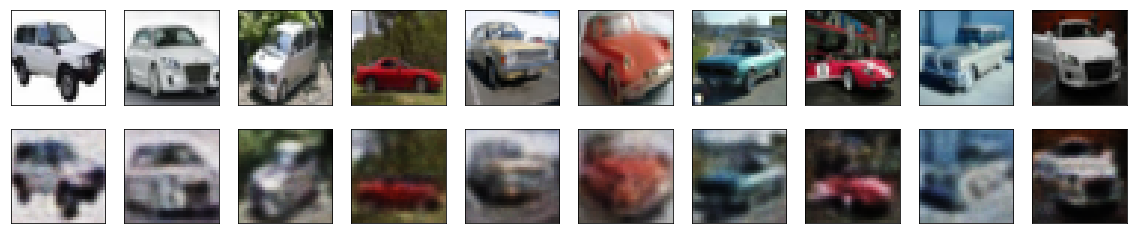

In [35]:
n = 10  # the number of panels to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # 50
    index = i + 50
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(car_test[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Are we actually learning car features? Using our autoencoder to classify cars (transfer learning)

### Training data

In [89]:
(x_train, y_train, x_test, y_test) = load_CIFAR10()

"""
We want a 50/50 split of cars and "not_cars" (birds, dogs, trucks, etc.)
Currently training set has a 1:9 split of cars and not_cars (50,000 examples: 5,000 cars and 45,000 not-cars). 

"""

# get indices of not_cars - should be 45,000 of them
indices_not_cars = np.where(y_train!=1)[0] # cars labeled with '1'

# delete 90% of the not_car rows so it's roughly equal: 5,000 cars and 4,500 not-cars. 
rows_to_delete = np.delete(indices_not_cars, np.s_[0:4500], axis=0)
x_train = np.delete(x_train, rows_to_delete, axis=0)
y_train = np.delete(y_train, rows_to_delete, axis=0)

# save the actual labels (0-9 for each class, like 'airplane', 'car', 'bird', etc.)
actual_labels = np.copy(y_train)
# set the labels of not_cars to 0
indices_not_cars = np.where(y_train!=1)[0] 
y_train[indices_not_cars] = 0

np.testing.assert_equal(x_train.shape[0], 9500)
np.testing.assert_equal(np.sum(y_train), 5000)


### Load autoencoder, freeze its layers, and add a classifier layer

In [26]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

model_base = model_from_json(open("saved_models/0.5276_dropout_car_conv_autoencoder_architecture.json").read())
model_base.load_weights("saved_models/0.5276_dropout_car_conv_autoencoder_weights")

# Freeze until the 3rd conv layer of the base model (our trained encoder)
for i in range(7):
    model_base.layers[i].trainable = False
x = model_base.layers[6].output
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

classifier = Model(model_base.input, x)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 64)          36928     
__________

In [6]:
classifier.layers

In [113]:
# My best classifiers - freeze first three learned car conv layers
classifier = load_model("saved_models/761_car_classifier_first_2_frozen")
# classifier = load_model("saved_models/840_car_classifier_first_3_frozen")

In [30]:

# train
classifier.fit(x_train, y_train, epochs=200, batch_size=256, shuffle=True,)

Epoch 1/200
9500/9500 [==============================] - 7s - loss: 0.4817 - binary_accuracy: 0.7877     
Epoch 2/200
9500/9500 [==============================] - 8s - loss: 0.4308 - binary_accuracy: 0.8166     
Epoch 3/200
9500/9500 [==============================] - 9s - loss: 0.3885 - binary_accuracy: 0.8372     
Epoch 4/200
9500/9500 [==============================] - 9s - loss: 0.3590 - binary_accuracy: 0.8493     
Epoch 5/200
9500/9500 [==============================] - 8s - loss: 0.3477 - binary_accuracy: 0.8569     
Epoch 6/200
9500/9500 [==============================] - 9s - loss: 0.3257 - binary_accuracy: 0.8656     
Epoch 7/200
9500/9500 [==============================] - 8s - loss: 0.3160 - binary_accuracy: 0.8702     
Epoch 8/200
9500/9500 [==============================] - 8s - loss: 0.3014 - binary_accuracy: 0.8784     
Epoch 9/200
9500/9500 [==============================] - 8s - loss: 0.2971 - binary_accuracy: 0.8809     
Epoch 10/200
3328/9500 [=========>............

KeyboardInterrupt: 

In [79]:
# classifier.save("840_car_classifier_first_3_frozen")

In [114]:
predictions = classifier.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print(predictions.shape)

(10000, 1)


#### Integrated Gradients

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


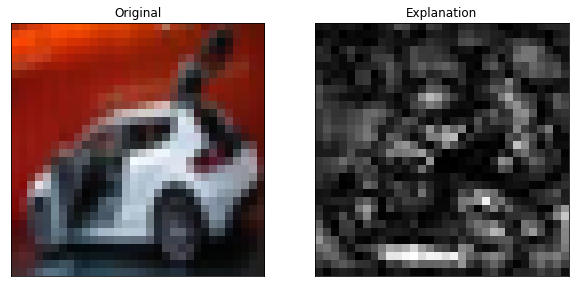

In [195]:
# 6, 37, 1020, 109, 123, 66, 81, 82, 104, 105, 114, 122, 134, 161, 193, 204, 231
# wheels!
# 6, 1020, 66, 81, 82, 105, 114, 122, 134, 161, 193, 204
ig = integrated_gradients(classifier)
ref = np.ones((32, 32, 3))
ref = np.expand_dims(ref, axis=0)
img = x_test[6]
exp = ig.explain(img, reference=ref[0]) # reference=ref[0]

exp = gray_scale(exp)
exp = abs(exp)
exp = np.clip(exp/np.percentile(exp, 99.99), 0,1)
vis = img*exp
### BLACK PIXEL experiment for IG with standard black image baseline
### USE WHITE AND BLACK BASELINES to get pixels with higher attribution (lighter and darker)
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         if np.average(img[i][j]) < 0.2:
#             if (np.average(exp[i][j] > 0.2)):
#                 print((i, j))
#     #           print(img[i][j])
#                 print(exp[i][j])
# print(exp[13, 24:27])
# print(img[13, 24:27])

# plot_side_by_side(img, vis, titles=["Original", "Explanation"])
plot_side_by_side(img, exp, titles=["Original", "Explanation"])

### Visualizing Conv Filters

In [84]:
l2 = classifier.layers[2]
l3 = classifier.layers[3]
l4 = classifier.layers[4]
l5 = classifier.layers[5]
l6 = classifier.layers[6]
l7 = classifier.layers[7]
l8 = classifier.layers[8]
l10 = classifier.layers[10]

x = l2(classifier.input)
x = l3(x)
x = l4(x)
x = l5(x)
x = l6(x)
x = l7(x)
x = l8(x)
output = l10(x)

classifier = Model(classifier.input, output)

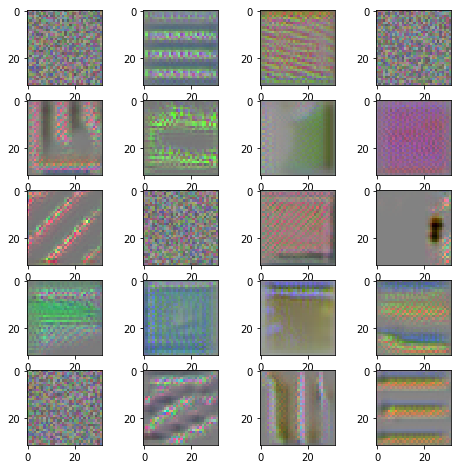

In [87]:
# Visualizing Conv Filters
from keras import backend as K

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
#     x = x.transpose((0, 1, 2))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    
    

layer_dict = dict([(layer.name, layer) for layer in classifier.layers])
layer_index = 5
input_img = classifier.input

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = classifier.layers[layer_index].get_output_at(1)
    
    loss = K.mean(layer_output[:, :, :, i+20])
    
    # compute the gradient of the loss wrt the input picture
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    
    # we start from a gray image with some noise
    input_img_data = (np.random.random((1, IMG_SIZE, IMG_SIZE, 3)) - 0.5) * 20 + 128

    # run gradient ascent for 20 steps
    four = 0
    for j in range(800):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * 1
        input_img_data = 0.995 * input_img_data
        input_img_data = cv2.GaussianBlur(input_img_data[0, :], (1, 1), 0)
        input_img_data = input_img_data.reshape(1, 32, 32, 3)
    
    img = input_img_data[0]
    img = deprocess_image(img)
    fig.add_subplot(rows, columns, i)   
    plt.imshow(img)
plt.show()


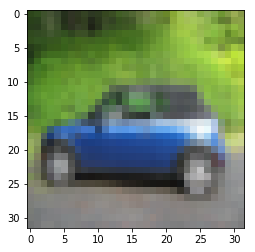

(1, 32, 32, 32)


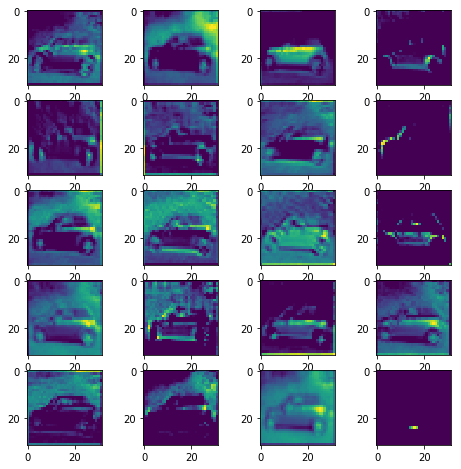

In [111]:
###### 
displayIndex = 82
plt.imshow(x_test[displayIndex])
plt.show()

desiredLayers = [2]
desiredOutputs = [classifier.layers[i].get_output_at(0) for i in desiredLayers] 

#alternatively, you can use cnnModel.get_layer('layername').output for that    

newModel = Model(classifier.inputs, desiredOutputs)
o = newModel.predict(x_test[displayIndex].reshape(1, 32, 32, 3))

print(o.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = o[0, :, :, i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### Extraordinary. Adding a single dense layer to the classifier (10) before the sigmoid improved loss from 0.19 (where it took forever and was converging) to 0.008. 

### Adding a Dropout layer to the Dense(10) layer improved test set performance by a lot. 

#### I think after enough iterations, it overfits the training set and does worse and worse on the test set. 

(32, 32, 3)


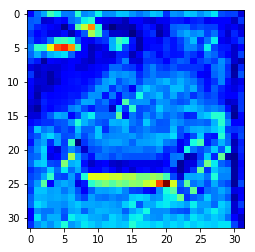

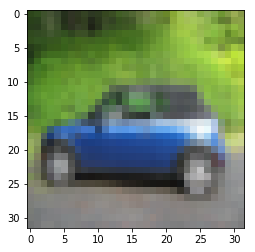

In [30]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations

# filter_idx = 95
# img = visualize_activation(classifier, 5, filter_indices=filter_idx)
# print(img.shape)
# plt.imshow(img[..., 0])
# plt.show()

class_idx = 1
grads = visualize_saliency(classifier, 5, filter_indices=class_idx, seed_input=x_test[82])
print(grads.shape)
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')
plt.show()

plt.imshow(x_test[82])
plt.show()

#### What does our classifier get confused by? 

In [99]:
# i have predictions: for every row, I have 0 or 1 the model's prediction on whether it's a car or not
# I have labels for every row: 0-9 based on the type of object it is
# I want to combine them so it's like
# model  label
# 1 .      4
# 1 .      1
# 1 .      6
# 0 .      1

# I want to construct a table
# so 4 has 5 1's, label 6 has 20 1's
# I want to filter it
# for every row, 
# if model's prediction is 1
# table[category[label]] += 1

# I have a dictionary from label (0 to 9) to its object (car, etc.) 

category_of = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
table = { 'plane': 0,'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}
total_counts = { 'plane': 0,'car': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}

misclassified_as_cars = []
cars_i = []

for i in range(predictions.shape[0]):
    c = category_of[y_test[i][0]]
    total_counts[c] += 1
    if predictions[i] == 1:
        if c != 'car':
            misclassified_as_cars.append(i)
        else:
            cars_i.append(i)
        table[c] += 1
        
print(table)
print(total_counts)

# {'plane': 73, 'car': 802, 'bird': 35, 'cat': 38, 
#  'deer': 22, 'dog': 28, 'frog': 38, 'horse': 44, 'ship': 168, 'truck': 378}

# {'plane': 109, 'car': 821, 'bird': 37, 'cat': 26, 
#  'deer': 14, 'dog': 12, 'frog': 14, 'horse': 26, 'ship': 209, 'truck': 505}

# {'plane': 42, 'car': 700, 'bird': 17, 'cat': 18, 
#  'deer': 6, 'dog': 17, 'frog': 14, 'horse': 15, 'ship': 116, 'truck': 360}


{'plane': 45, 'car': 761, 'bird': 20, 'cat': 18, 'deer': 7, 'dog': 15, 'frog': 12, 'horse': 13, 'ship': 105, 'truck': 324}
{'plane': 1000, 'car': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


1795
1808
1814
1815
1820
1831
1834
1837
1841
1853
1893
1897
1938
1947
1980
1988
1993
2007
2008
2020


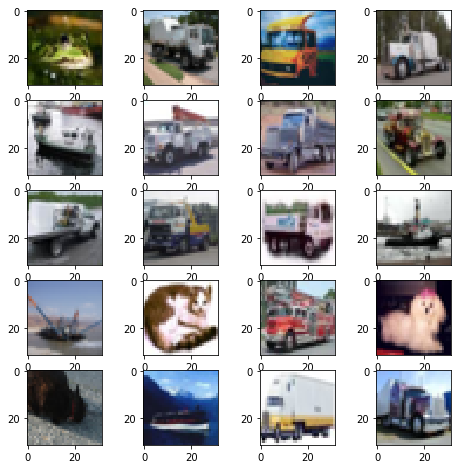

In [100]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = x_test[misclassified_as_cars[i+90]]
    print(misclassified_as_cars[i+90])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### How much of each category does our classifier think is a car?

#### 'car': 900/1000  
#### 'truck': 574/1000  
#### 'ship': 252/1000  
#### 'plane': 123/1000  
#### 'frog': 75/1000  
#### 'cat': 65/1000 
#### 'horse': 56/1000   
#### 'bird': 44/1000  
#### 'deer': 33/1000
#### 'dog': 32/1000  

### Things I Learned

* Adding a fully-connected layer (size 10) before the classification (1, sigmoid) led to far better performance on the test set. I think it's because there were 10 classes? Not sure. 
* **Dropout** (on both the car autoencoder and the car classifier) led to much better performance on the test set. It classified more cars while making less mistakes than other categories (like 'deer' and 'horse'). 